# Base de dades MySQL
**Descripció**  
Crear base de dades amb MySQL.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sqlalchemy as sa
from sqlalchemy.exc import IntegrityError

import mysql.connector

import configparser


In [2]:
# dades de configuració de la base de dades

config = configparser.ConfigParser()
config.read('../config/delayedflights_db.cfg')

host = config.get('mysqlDB','host')
user = config.get('mysqlDB','user')
passwd = config.get('mysqlDB','pass')
db = config.get('mysqlDB','db')

## Nivell 1
### Exercici 1
Crea una base de dades relacionals senzilla utilitzant MySQL(https://www.mysql.com/) i connecta-la a Python

### Hem creat una BBDD a partir de les dades de delayedflights

L'estructura es així:
- Airport (**airport_id**, airport_name, city, country, lat, lon, timezone, Timezone_idTimezone)
- Carrier (**carrier_id**, name)
- Routes (Distance, Origin, Destination)
- Timezone (**idTimezone**, timezone)
- Flights (**Date**, Carrier, Routes_Origin, Routes_Destination, FlightNum, TailNum, DepDelay, ArrDelay)


l'script de creació de la bbdd es aquest

```sql
-- MySQL Script generated by MySQL Workbench
-- Wed Jul 14 16:47:36 2021
-- Model: New Model    Version: 1.0
-- MySQL Workbench Forward Engineering

SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0;
SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0;
SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='ONLY_FULL_GROUP_BY,STRICT_TRANS_TABLES,NO_ZERO_IN_DATE,NO_ZERO_DATE,ERROR_FOR_DIVISION_BY_ZERO,NO_ENGINE_SUBSTITUTION';

-- -----------------------------------------------------
-- Schema delayedflights
-- -----------------------------------------------------

-- -----------------------------------------------------
-- Schema delayedflights
-- -----------------------------------------------------
CREATE SCHEMA IF NOT EXISTS `delayedflights` DEFAULT CHARACTER SET utf8mb4 COLLATE utf8mb4_0900_ai_ci ;
USE `delayedflights` ;

-- -----------------------------------------------------
-- Table `delayedflights`.`Timezone`
-- -----------------------------------------------------
CREATE TABLE IF NOT EXISTS `delayedflights`.`Timezone` (
  `idTimezone` INT NOT NULL,
  `timezone` VARCHAR(45) NOT NULL,
  PRIMARY KEY (`idTimezone`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8mb4
COLLATE = utf8mb4_0900_ai_ci;


-- -----------------------------------------------------
-- Table `delayedflights`.`Airport`
-- -----------------------------------------------------
CREATE TABLE IF NOT EXISTS `delayedflights`.`Airport` (
  `airport_id` VARCHAR(3) NOT NULL,
  `airport_name` VARCHAR(45) NOT NULL,
  `city` VARCHAR(45) NULL DEFAULT NULL,
  `country` VARCHAR(4) CHARACTER SET 'utf8mb4' COLLATE 'utf8mb4_0900_ai_ci' NULL DEFAULT NULL,
  `lat` DECIMAL(10,6) NULL DEFAULT NULL,
  `lon` DECIMAL(10,6) NULL DEFAULT NULL,
  `timezone` VARCHAR(45) NULL DEFAULT NULL,
  `Timezone_idTimezone` INT NOT NULL,
  PRIMARY KEY (`airport_id`, `Timezone_idTimezone`),
  INDEX `fk_Airport_Timezone1_idx` (`Timezone_idTimezone` ASC) VISIBLE,
  CONSTRAINT `fk_Airport_Timezone1`
    FOREIGN KEY (`Timezone_idTimezone`)
    REFERENCES `delayedflights`.`Timezone` (`idTimezone`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8mb4
COLLATE = utf8mb4_0900_ai_ci;


-- -----------------------------------------------------
-- Table `delayedflights`.`Carrier`
-- -----------------------------------------------------
CREATE TABLE IF NOT EXISTS `delayedflights`.`Carrier` (
  `carrier_id` VARCHAR(3) NOT NULL,
  `name` VARCHAR(255) NOT NULL,
  PRIMARY KEY (`carrier_id`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8mb4
COLLATE = utf8mb4_0900_ai_ci;


-- -----------------------------------------------------
-- Table `delayedflights`.`Routes`
-- -----------------------------------------------------
CREATE TABLE IF NOT EXISTS `delayedflights`.`Routes` (
  `Distance` INT UNSIGNED NOT NULL,
  `Origin` VARCHAR(3) NOT NULL,
  `Destination` VARCHAR(3) NOT NULL,
  PRIMARY KEY (`Origin`, `Destination`),
  INDEX `fk_Routes_Airport1_idx` (`Origin` ASC) VISIBLE,
  INDEX `fk_Routes_Airport2_idx` (`Destination` ASC) VISIBLE,
  CONSTRAINT `fk_Routes_Airport1`
    FOREIGN KEY (`Origin`)
    REFERENCES `delayedflights`.`Airport` (`airport_id`),
  CONSTRAINT `fk_Routes_Airport2`
    FOREIGN KEY (`Destination`)
    REFERENCES `delayedflights`.`Airport` (`airport_id`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8mb4
COLLATE = utf8mb4_0900_ai_ci;


-- -----------------------------------------------------
-- Table `delayedflights`.`Flights`
-- -----------------------------------------------------
CREATE TABLE IF NOT EXISTS `delayedflights`.`Flights` (
  `Carrier` VARCHAR(3) NOT NULL,
  `Date` DATETIME NOT NULL,
  `Routes_Origin` VARCHAR(3) NOT NULL,
  `Routes_Destination` VARCHAR(3) NOT NULL,
  `FlightNum` VARCHAR(6) CHARACTER SET 'utf8mb4' COLLATE 'utf8mb4_0900_ai_ci' NULL DEFAULT NULL,
  `TailNum` VARCHAR(10) CHARACTER SET 'utf8mb4' COLLATE 'utf8mb4_0900_ai_ci' NULL DEFAULT NULL,
  `DepDelay` INT UNSIGNED NOT NULL,
  `ArrDelay` INT NULL DEFAULT NULL,
  INDEX `fk_Carrier_has_Airport_Carrier_idx` (`Carrier` ASC) VISIBLE,
  INDEX `fk_Flights_Routes1_idx` (`Routes_Origin` ASC, `Routes_Destination` ASC) VISIBLE,
  CONSTRAINT `fk_Carrier_has_Airport_Carrier`
    FOREIGN KEY (`Carrier`)
    REFERENCES `delayedflights`.`Carrier` (`carrier_id`),
  CONSTRAINT `fk_Flights_Routes1`
    FOREIGN KEY (`Routes_Origin` , `Routes_Destination`)
    REFERENCES `delayedflights`.`Routes` (`Origin` , `Destination`))
ENGINE = InnoDB
DEFAULT CHARACTER SET = utf8mb4
COLLATE = utf8mb4_0900_ai_ci;


SET SQL_MODE=@OLD_SQL_MODE;
SET FOREIGN_KEY_CHECKS=@OLD_FOREIGN_KEY_CHECKS;
SET UNIQUE_CHECKS=@OLD_UNIQUE_CHECKS;
```

Aquest es l'esquema:   

![Delayed Flights simple](../images/delayedflights-sql.png)


### Creem els dataframes per inserir-los a la BBDD
> si la base de dades ja te les dades, donarà error al carregar

#### Creem el dataframe per a Timezone

In [5]:
df = pd.read_pickle('../data/CleanDelayedFlights.pickle')

In [6]:
dftimezone = pd.DataFrame(df.TZ_Origin.unique(), columns=['timezone'])

engine = sa.create_engine(f"mysql+mysqlconnector://{user}:{passwd}@{host}:3306/{db}")

# Afegim les dades de timezone
try:
    with engine.connect() as conn:
        dftimezone.to_sql('Timezone', conn, if_exists='append',index_label='idTimezone')
        
except (ValueError, IntegrityError):
    print('La taula ja està previament creada i conté dades')

    

La taula ja està previament creada i conté dades


#### Creem el dataframe per a Carrier

In [7]:
dfcarriers = df[['UniqueCarrier', 'carrier_name' ]].drop_duplicates().set_index('UniqueCarrier')
dfcarriers.columns = ['name']

# Inserim les dades de les companyies
try: 
    with engine.connect() as conn:
        dfcarriers.to_sql('Carrier', conn, if_exists='append', index_label='carrier_id')
    
except (ValueError, IntegrityError):
    print('La taula ja està previament creada i conté dades')

    

La taula ja està previament creada i conté dades


#### Creem el dataframe per a Airports

Airport ( *airport_id*, airport_name, city, country, lat, lon, timezone, Timezone_idTimezone-fk- )

In [8]:
dfairports = pd.read_csv('http://stat-computing.org/dataexpo/2009/airports.csv', index_col=0)

dfairports.reset_index()[['iata','airport','city','country','lat','long']]

,iata,airport,city,country,lat,long
0,00M,Thigpen,Bay Springs,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,USA,30.688012,-81.905944
...,...,...,...,...,...,...
3371,ZEF,Elkin Municipal,Elkin,USA,36.280024,-80.786069
3372,ZER,Schuylkill Cty/Joe Zerbey,Pottsville,USA,40.706449,-76.373147
3373,ZPH,Zephyrhills Municipal,Zephyrhills,USA,28.228065,-82.155916
3374,ZUN,Black Rock,Zuni,USA,35.083227,-108.791777


In [9]:
col_map = {'Origin':'airport_id', 'Name_Origin':'airport_name', 'Dest':'airport_id', 'Name_Dest':'airport_name', 'TZ_Origin':'timezone', 'TZ_Dest':'timezone'}
df_airports = pd.concat((df[['Origin','Name_Origin','TZ_Origin']].rename(columns=col_map), df[['Dest','Name_Dest','TZ_Dest']].rename(columns=col_map)), axis=0).drop_duplicates()

In [10]:
df_airports['country'] = df_airports.airport_id.map(dfairports.to_dict()['country'])
df_airports['city'] = df_airports.airport_id.map(dfairports.to_dict()['city'])
df_airports['lat'] = df_airports.airport_id.map(dfairports.to_dict()['lat'])
df_airports['lon'] = df_airports.airport_id.map(dfairports.to_dict()['long'])

timezones = {v: k for k, v in dftimezone.to_dict()['timezone'].items()} 
df_airports['Timezone_idTimezone'] = df_airports.timezone.map(timezones)
df_airports.set_index('airport_id', inplace=True)

In [11]:
try: 
    with engine.connect() as conn:
        df_airports.to_sql('Airport', conn, if_exists='append', index_label='airport_id')
except (ValueError, IntegrityError):
    print('La taula ja està previament creada i conté dades')

    

La taula ja està previament creada i conté dades


#### Routes

Routes (Distance, Origin, Destination)

In [12]:
dfroutes = df.groupby(['Origin','Dest']).Distance.mean().reset_index()
dfroutes.columns = ['Origin','Destination','Distance']
dfroutes.set_index(['Origin','Destination'], inplace=True)

In [13]:
try:
    with engine.connect() as conn:
        dfroutes.to_sql('Routes', conn, if_exists='append', index_label=['Origin','Destination'])
except (ValueError, IntegrityError):
    print('La taula ja està previament creada i conté dades')


La taula ja està previament creada i conté dades


#### Flights

Flights (Date, *Carrier*, *Routes_Origin*, *Routes_Destination*, FlightNum, TailNum, DepDelay, ArrDelay)

In [14]:
cols = ['DepartureTime', 'UniqueCarrier', 'Origin', 'Dest', 'FlightNum', 'TailNum', 'DepDelay', 'ArrDelay']
dfflights = df[cols]
# dfflights.drop_duplicates(inplace=True)
dfflights.columns = ['Date', 'Carrier', 'Routes_Origin','Routes_Destination', 'FlightNum','TailNum','DepDelay','ArrDelay']
dfflights.set_index(['Date','Carrier','Routes_Origin','Routes_Destination'], inplace=True)


In [15]:
try:
    with engine.connect() as conn:
        dfflights.sample(int(1e5)).to_sql('Flights', conn, if_exists='append', index_label=dfflights.index.names)
except (ValueError, IntegrityError):
    print('La taula ja està previament creada i conté dades')


## Nivell 2
### Exercici 2
Mostra que pots carregar algunes consultes senzilles a un Pandas Dataframe.

In [16]:

mydb = mysql.connector.connect(
  host=host,
  user=user,
  password=passwd,
  database=db
)

print(mydb)

#### Mirem les taules

In [17]:
mycursor = mydb.cursor()

mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)

('Airport',)
('Carrier',)
('Flights',)
('Routes',)
('Timezone',)


In [18]:
# una altra manera de fer-ho

mycursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'delayedflights'")
mycursor.fetchall()

[('Airport',), ('Carrier',), ('Flights',), ('Routes',), ('Timezone',)]

#### Mirem el contingut d'una taula (carrier)

In [19]:
mycursor.execute('select * from `carrier`')
tables = []
for x in mycursor:
    print(x)
    tables.append(x) 

('9E', 'Endeavor Air Inc.')
('AA', 'American Airlines Inc.')
('AQ', 'Aloha Airlines Inc.')
('AS', 'Alaska Airlines Inc.')
('B6', 'JetBlue Airways')
('CO', 'Continental Air Lines Inc.')
('DL', 'Delta Air Lines Inc.')
('EV', 'ExpressJet Airlines LLC')
('F9', 'Frontier Airlines Inc.')
('FL', 'AirTran Airways Corporation')
('HA', 'Hawaiian Airlines Inc.')
('MQ', 'Envoy Air')
('NW', 'Northwest Airlines Inc.')
('OH', 'PSA Airlines Inc.')
('OO', 'SkyWest Airlines Inc.')
('UA', 'United Air Lines Inc.')
('US', 'US Airways Inc.')
('WN', 'Southwest Airlines Co.')
('XE', 'ExpressJet Airlines Inc.')
('YV', 'Mesa Airlines Inc.')


## Nivell 3
### Exercici 3
Genera algun gràfic que resumeixi les dades. 

#### Mirem el número de vols per dia

##### agafant tots els vols de la taula

In [20]:
cursor = mydb.cursor()
cursor.execute('select * from Flights')
flights_df = pd.DataFrame(data=list(cursor),columns = cursor.column_names)


In [21]:
flights_df.shape

(200000, 8)

<AxesSubplot:xlabel='Date'>

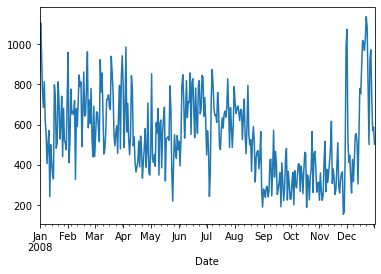

In [22]:
flights_df.groupby(pd.Grouper(key='Date', freq='D')).DepDelay.count().plot()

##### o fent una consulta directament amb sql

In [23]:
cursor = mydb.cursor()
cursor.execute('select date(flights.date) as data , count(*) \
                from Flights \
                group by data')
vols_dia_df = pd.DataFrame(data=list(cursor),columns = cursor.column_names)


<AxesSubplot:xlabel='data'>

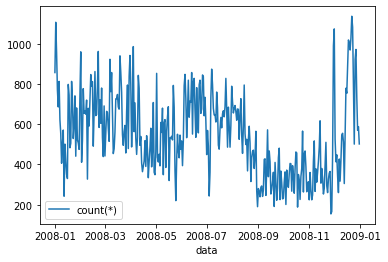

In [24]:
vols_dia_df.set_index('data').plot()

#### Distàncies recorregudes per les aerolínies

In [25]:
cursor = mydb.cursor()
cursor.execute('select flights.carrier, carrier.name, sum(distance) from flights \
               left join carrier on flights.carrier = carrier.carrier_id \
               left join routes on flights.Routes_Origin = routes.origin \
               and flights.routes_destination = routes.destination \
               group by flights.carrier, carrier.name')
distances_df = pd.DataFrame(list(cursor), columns=cursor.column_names)

distances_df.columns = ['carrier','carrier_name','distance']

In [26]:
distances_df['distance'] = distances_df.distance.astype('int')

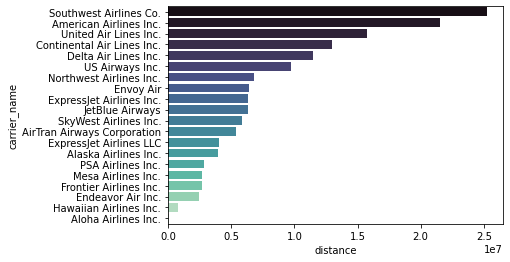

In [28]:
g = sns.barplot(data=distances_df.sort_values('distance', ascending=False), y='carrier_name', x='distance', palette='mako')